<a href="https://colab.research.google.com/github/nikyan/spark_customer_churn/blob/master/sparkify_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparkify Project Workspace
This Notebook contains a tiny subset (128MB) of the full dataset available (12GB). This workspace is used to explore a smaller subset with Spark before deploying on a cluster on the cloud.

The purpose of this Notebook is to explore data and identify features that can be useful for modeling.

# Google Colab Spark Setup and Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# setup Spark session on Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirrors.hoobly.com/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
# create Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import udf, col, concat, count, lit, isnan, when, desc, split, trim
import pyspark.sql.functions as F
from pyspark.sql.types import *
import datetime

import numpy as np
import pandas as pd
import re
#import regex

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load and clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [0]:
path = "/content/drive/My Drive/ML data/mini_sparkify_event_data.json"
event_data = spark.read.json(path)

In [6]:
event_data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [7]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# get original count of rows
event_data.count()

286500

In [9]:
# check for nans and nulls
event_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in event_data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



There are no nans or nulls in userId or sessionId. Check for empty strings.

In [10]:
event_data.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [11]:
event_data.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



No empty strings in sessionId. Remove empty string from userId.

In [12]:
# remove empty string from userId
event_data=event_data.filter(event_data.userId != "")
event_data.count()

278154

# Exploratory Data Analysis

 ### Check for unique values in each column

In [13]:
# check for unique values in each column and empty strings
for col in event_data.columns:
    event_data.select(col).dropDuplicates().show()

+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+----------+
| firstName|
+----------+
|    Maddox|
|    Karter|
|     Lucas|
|     Grace|
|  Antonina|
|   Lorelei|
|   Adriana|
|  Isabella|
|     James|
|    Brooke|
|  Benjamin|
|  Giovanni|
|     Davis|
|    Nathan|
|   Antonio|
| Christian|
|     Brisa|
|Alexandria|
|   Spencer|
|    Jordan|
+----------+
only showing top 20 rows

+------+
|g

In [14]:
# Number of unique users in the dataset
event_data.select("userId").dropDuplicates().count()

225

### Data observations:

 - userId & sessionId: primary keys
 - numerical variables:
     - length: length of song
     - itemInSession
     - status: http status
 - character variables:
     - artist: name of artist
     - song: name of song
     - auth: type of authorisation
     - firstName
     - lasName
     - gender: M or F
     - level: free or paid user
     - location: user location
     - method: http method (get or put)
     - page: pages viewed by user
     - userAgent: operating system or device of user
 - Datetime
     - registration: registration timestamp
     - ts: timestamp per session id

### Add Features

Create a funcitons to get hour, month, year and date from timestamp.



In [0]:
# #create a function to get hour from timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

# create a funciton to get month from timestamp
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

# create a function to get month from timestamp
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).year)

# create a function to get date from timestamp
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)

In [0]:
# add month and year to the dataframe
#event_data = event_data.withColumn("minute", get_min(event_data.ts))
event_data = event_data.withColumn("hour", get_hour(event_data.ts))
event_data = event_data.withColumn("month", get_month(event_data.ts))
event_data = event_data.withColumn("year", get_year(event_data.ts))
event_data = event_data.withColumn("day", get_day(event_data.ts))
event_data = event_data.withColumn("date", from_unixtime(event_data.ts/1000).cast(DateType()))

In [17]:
event_data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0', month='10', year='2018', day='1', date=datetime.date(2018, 10, 1))

#### Calculate churn

Filter for page == 'Cancellation Confirmation'.

In [18]:
# lets look at page = 'Cancellation Confirmation'
event_data.filter(event_data.page == 'Cancellation Confirmation').show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+-----+----+---+----------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|month|year|day|      date|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----+-----+----+---+----------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|  20|   10|2018|  7|2018-10-07|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoe

Let's look at a user who cancelled subscription.
Looks like cancellation confirmation is a good indication of churn.

In [19]:
event_data.select(["userId", "page", "level", "sessionId", "ts"]).where(event_data.userId == "125").collect()

[Row(userId='125', page='NextSong', level='free', sessionId=174, ts=1539317144000),
 Row(userId='125', page='NextSong', level='free', sessionId=174, ts=1539317481000),
 Row(userId='125', page='NextSong', level='free', sessionId=174, ts=1539317711000),
 Row(userId='125', page='NextSong', level='free', sessionId=174, ts=1539317914000),
 Row(userId='125', page='NextSong', level='free', sessionId=174, ts=1539318124000),
 Row(userId='125', page='NextSong', level='free', sessionId=174, ts=1539318515000),
 Row(userId='125', page='NextSong', level='free', sessionId=174, ts=1539318728000),
 Row(userId='125', page='NextSong', level='free', sessionId=174, ts=1539318906000),
 Row(userId='125', page='Roll Advert', level='free', sessionId=174, ts=1539318917000),
 Row(userId='125', page='Cancel', level='free', sessionId=174, ts=1539318918000),
 Row(userId='125', page='Cancellation Confirmation', level='free', sessionId=174, ts=1539318918000)]

'Cancel' and 'Cancellation Confirmation' page events are generally in sequence.
We will identify a churned user when the user has visited 'Cancellation Confirmation':

In [0]:
# function to flag 'cancellation confirmation' event
flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
event_data = event_data.withColumn("churn", flag_cancel_event("page"))

In [21]:
event_data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0', month='10', year='2018', day='1', date=datetime.date(2018, 10, 1), churn=0)

### Sql Temp View

Create a SQL temp view for EDA.

In [0]:
# temp view for SQL queries
event_data.createOrReplaceTempView("event_data")

### User Id by active or churned status

Create a table that idenfies whether a user is active or churned.

In [0]:
users_churn = spark.sql('''
          SELECT userId, MAX(churn) as churn
          FROM event_data
          GROUP BY userId
          ORDER BY userId
          '''
          )

In [0]:
# this datafame can used to identify between active and churned user
users_churn_pd = users_churn.toPandas()

Create a table that identifies the most recent level of the user.

In [0]:
# use timestamp to identify the most latest record for a user
# sort timestamp in descending order and than drop duplicates to get the last row for each user
latest_level = event_data.select(['userId', 'level', 'ts'])\
                    .orderBy(desc('ts'))\
                    .dropDuplicates(['userId'])\
                    .select(['userId', 'level'])

latest_level_pd = latest_level.toPandas()

Utility functions:

In [0]:
# function to calculate churn rate given count of active and churned users

def get_churn_rate(df):
    '''
    Funtion to calculate churn rate given a dataframe of active and churned users
    INPUT:
    df - spark dataframe
    OUPUT:
    df - df with churn rate column
    '''
    conditions = [(df['churned_users'] == 0), (df['churned_users'] != 0)]
    choices = [0, round(df['churned_users']/df['active_users'], 2)]
    df['churn_rate'] = np.select(conditions, choices, default=0)


# funtion to prepare data for visualization having churn 
def get_data_vis(df, index, columns, values):
    '''
    Function to prepare data for visualization
    INPUT:
    df - spark dataframe
    index - column that will be used as index
    columns - columns used for pivot
    values - the value column that will be used for pivot 
    OUPUT:
    df - pivoted dataframe
    '''
    if isinstance(df, pd.DataFrame):
        df_pd = df
    else:
        df_pd = df.toPandas()
        
    df_pd = df_pd.pivot(index = index, columns = columns, values = values)
    df_pd.rename(columns={0: 'active_users', 1: 'churned_users'}, inplace=True)
    df_pd = df_pd.fillna(0)

    #get_churn_rate(df_pd)
    df_pd.reset_index(level=0, inplace=True)
    
    return df_pd

### Churn by month, date and day

Churn by month:

In [0]:
users_churn_mon = spark.sql('''
          SELECT month, MAX(churn) as churn, COUNT(DISTINCT(userId)) as count_userId
          FROM event_data
          GROUP BY month, churn
          ORDER BY month ASC
          '''
          )

In [0]:
# convert to pandas dataframe for visualization
users_churn_mon_pd = get_data_vis(users_churn_mon, "month", "churn", "count_userId")

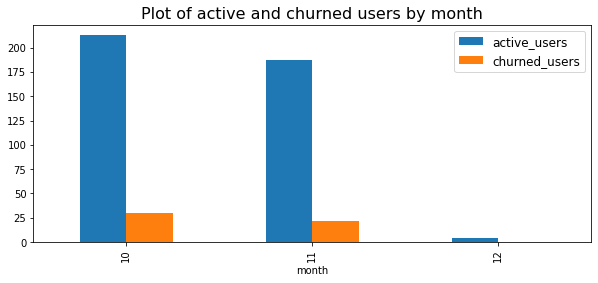

In [29]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
users_churn_mon_pd.plot(x = 'month', y = ['active_users', 'churned_users'], ax = ax, kind="bar")
ax.set_title("Plot of active and churned users by month", fontsize=16);
plt.legend(prop={'size': 12})
plt.show()

Churn by date:

In [0]:
users_churn_date = spark.sql('''
          SELECT date, MAX(churn) as churn, COUNT(DISTINCT(userId)) as count_userId
          FROM event_data
          GROUP BY date, churn
          ORDER BY date ASC
          '''
          )

In [0]:
# convert to pandas dataframe for visualization
users_churn_date_pd = get_data_vis(users_churn_date, 'date', 'churn', 'count_userId')

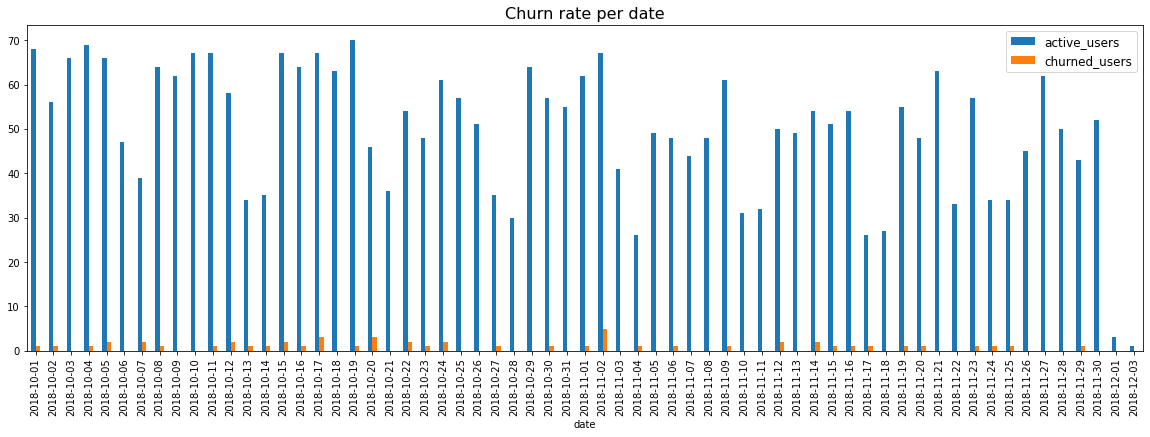

In [32]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
users_churn_date_pd.plot(x = 'date', y = ['active_users', 'churned_users'], ax = ax, kind="bar")
ax.set_title("Churn rate per date", fontsize=16)
plt.legend(prop={'size': 12})
plt.show();

Churn by day:

In [0]:
users_churn_day = spark.sql('''
          SELECT day, MAX(churn) as churn, COUNT(DISTINCT(userId)) as count_userId
          FROM event_data
          GROUP BY day, churn
          ORDER BY day ASC
          '''
          )

In [0]:
# convert to pandas dataframe for visualization
users_churn_day_pd = get_data_vis(users_churn_day, 'day', 'churn', 'count_userId')

In [0]:
users_churn_day_pd["day"] = pd.to_numeric(users_churn_day_pd["day"])
users_churn_day_pd.sort_values('day', inplace=True)

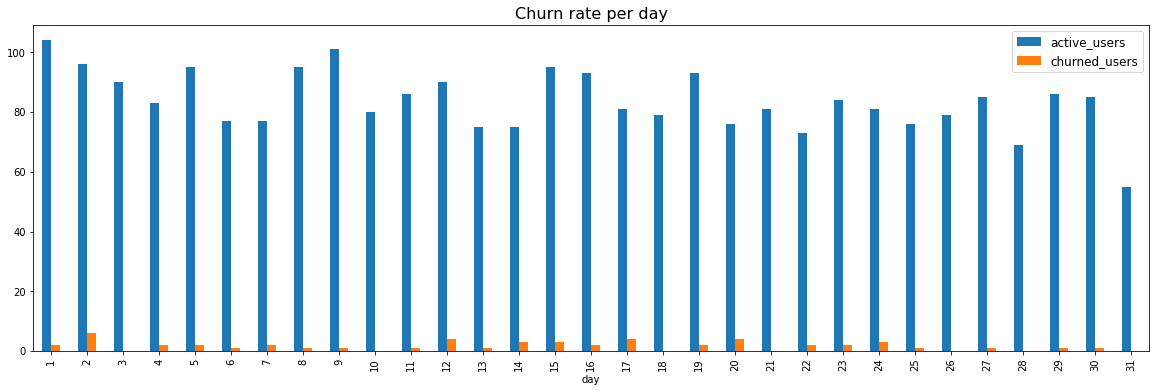

In [36]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
users_churn_day_pd.plot(x = 'day', y = ['active_users', 'churned_users'], ax = ax, kind="bar")
ax.set_title("Churn rate per day", fontsize=16)
plt.legend(prop={'size': 12})
plt.show();

Looking at active/churned users by date/day doesn't really help.

### Gender

In [0]:
users_gender = spark.sql('''
          SELECT gender, COUNT(DISTINCT(userId)) as count_userId
          FROM event_data
          GROUP BY gender
          '''
          )

In [38]:
users_gender.show()

+------+------------+
|gender|count_userId|
+------+------------+
|     F|         104|
|     M|         121|
+------+------------+



There are more male users than female users.

In [0]:
users_churn_gender = spark.sql('''
          SELECT gender, churn, SUM(count_userId) as count_userId
          FROM (SELECT userId, gender, MAX(churn) as churn, COUNT(DISTINCT(userId)) as count_userId
          FROM event_data
          GROUP BY userId, gender)
          GROUP BY gender, churn
          ORDER BY gender, churn
          '''
          )

In [0]:
users_churn_gender_pd = get_data_vis(users_churn_gender, 'gender', 'churn', 'count_userId')

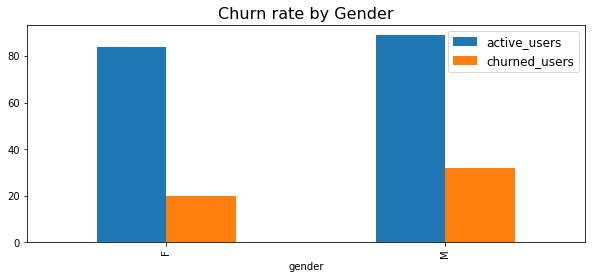

In [41]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
users_churn_gender_pd.plot(x = 'gender', y = ['active_users', 'churned_users'], ax = ax, kind="bar")
ax.set_title("Churn rate by Gender", fontsize=16)
plt.legend(prop={'size': 12})
plt.show()

More male users and hence higher rate of churn as well.

### Churn by level

In [0]:
# free vs paid
users_churn_level = spark.sql('''
          SELECT userId, MAX(churn) as churn, COUNT(DISTINCT(userId)) as count_userId
          FROM event_data
          GROUP BY userId
          '''
          )

In [0]:
# convert to pandas df and join with df with latest level
users_churn_level_pd = users_churn_level.toPandas()
users_churn_level_pd = pd.merge(users_churn_level_pd, latest_level_pd, on='userId')

In [0]:
# groupby level and churn and reset index
users_churn_level_pd = users_churn_level_pd.groupby(['level', 'churn']).sum()
users_churn_level_pd.reset_index(inplace=True)

In [0]:
# call the pivot function
users_churn_level_pd = get_data_vis(users_churn_level_pd, 'level', 'churn', 'count_userId')

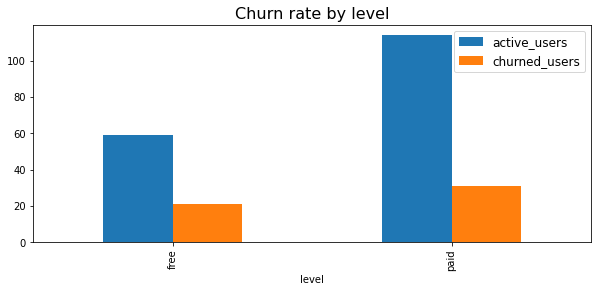

In [46]:
# visualize
fig, ax = plt.subplots(1,1,figsize=(10,4))
users_churn_level_pd.plot(x = 'level', y = ['active_users', 'churned_users'], ax = ax, kind="bar")
ax.set_title("Churn rate by level", fontsize=16)
plt.legend(prop={'size': 12})
plt.show();

Free users seems to have higher churn rate.

### Churn by location

In [0]:
# Distribution of users by location
users_location = spark.sql('''
          SELECT location, COUNT(DISTINCT(userId)) as count_userId
          FROM event_data
          GROUP BY location
          ORDER BY count_userId DESC
          '''
          )

In [48]:
# top 20 locations
users_location.show()

+--------------------+------------+
|            location|count_userId|
+--------------------+------------+
|Los Angeles-Long ...|          16|
|New York-Newark-J...|          15|
|Phoenix-Mesa-Scot...|           7|
|Dallas-Fort Worth...|           7|
|Chicago-Napervill...|           6|
|    St. Louis, MO-IL|           6|
|Charlotte-Concord...|           6|
|Miami-Fort Lauder...|           5|
|Philadelphia-Camd...|           5|
|Boston-Cambridge-...|           5|
|Atlanta-Sandy Spr...|           4|
|Washington-Arling...|           4|
|Houston-The Woodl...|           4|
|San Diego-Carlsba...|           3|
|Las Vegas-Henders...|           3|
|New Haven-Milford...|           3|
|Greenville-Anders...|           2|
|         Jackson, MS|           2|
|Indianapolis-Carm...|           2|
|San Antonio-New B...|           2|
+--------------------+------------+
only showing top 20 rows



In [0]:
users_churn_location = spark.sql('''
          SELECT location, churn, COUNT(DISTINCT(userId)) as count_userId
          FROM event_data
          GROUP BY location, churn
          ORDER BY location, churn
          '''
          )

In [0]:
users_churn_location_pd = get_data_vis(users_churn_location, 'location', 'churn', 'count_userId')

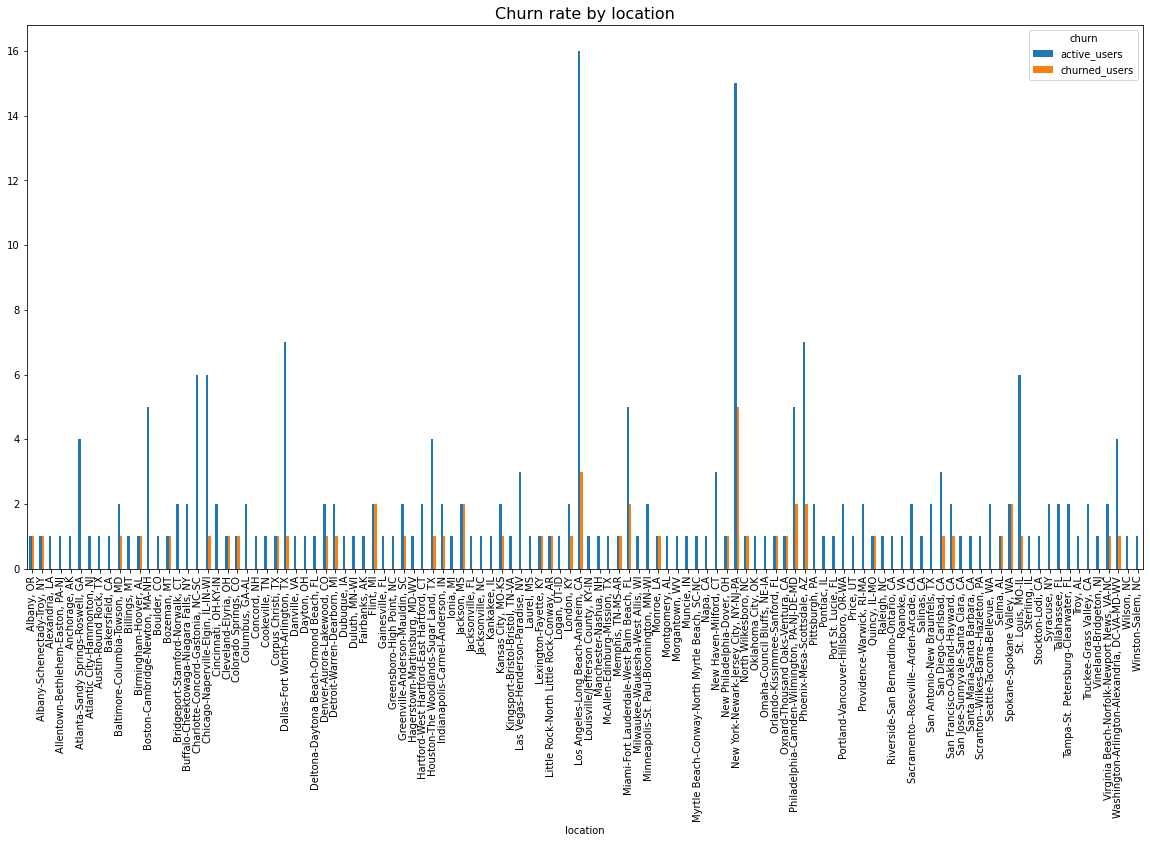

In [51]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
users_churn_location_pd.plot(x = 'location', y = ['active_users', 'churned_users'], ax = ax, kind="bar")
ax.set_title("Churn rate by location", fontsize=16);
plt.show()

There are too many locations to find meaningful pattern. We will clean up location and extract state.

In [0]:
# extract state
users_churn_location_pd['state'] = users_churn_location_pd['location'].str.split(',').str[1]

In [0]:
users_churn_location_pd = users_churn_location_pd.groupby('state').sum()
users_churn_location_pd.reset_index(inplace=True)

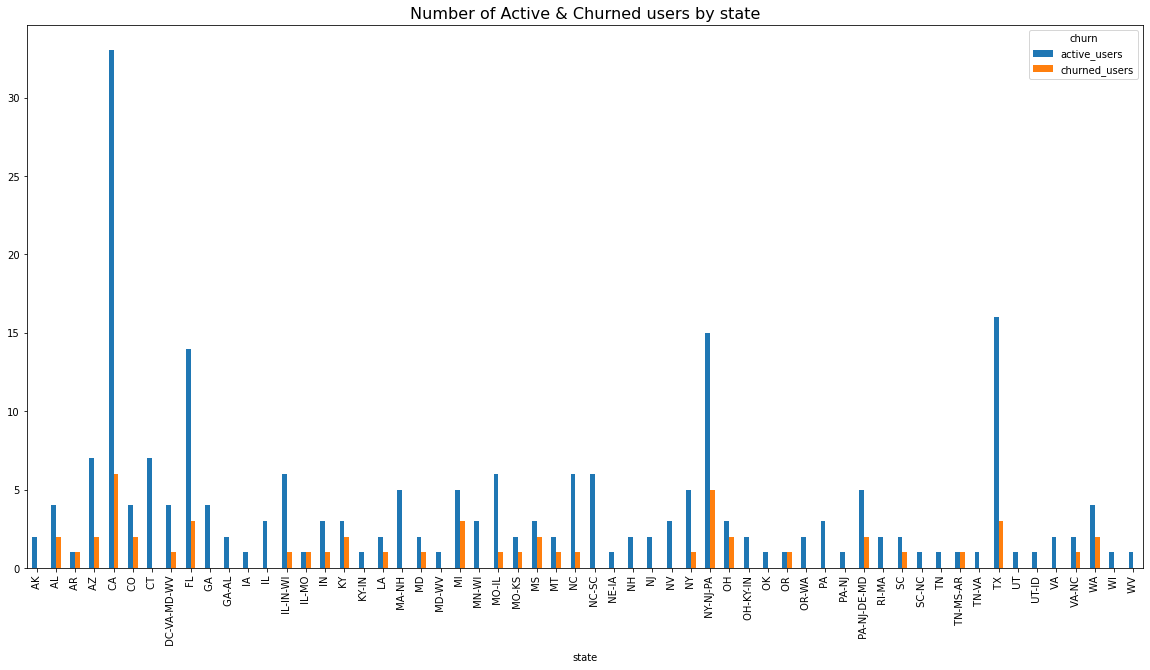

In [54]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
users_churn_location_pd.plot(x = 'state', y = ['active_users', 'churned_users'], ax = ax, kind="bar")
ax.set_title("Number of Active & Churned users by state", fontsize=16);
plt.show()

There is definitely some correlation with state. Some states have higher churn rate.

### Churn by userAgent

In [0]:
users_churn_userAgent = spark.sql('''
          SELECT userAgent, Max(churn) as churn, COUNT(DISTINCT(userId)) as count_userId
          FROM event_data
          GROUP BY userAgent, churn
          ORDER BY userAgent, churn
          '''
          )

In [0]:
users_churn_userAgent_pd = get_data_vis(users_churn_userAgent, 'userAgent', 'churn', 'count_userId')

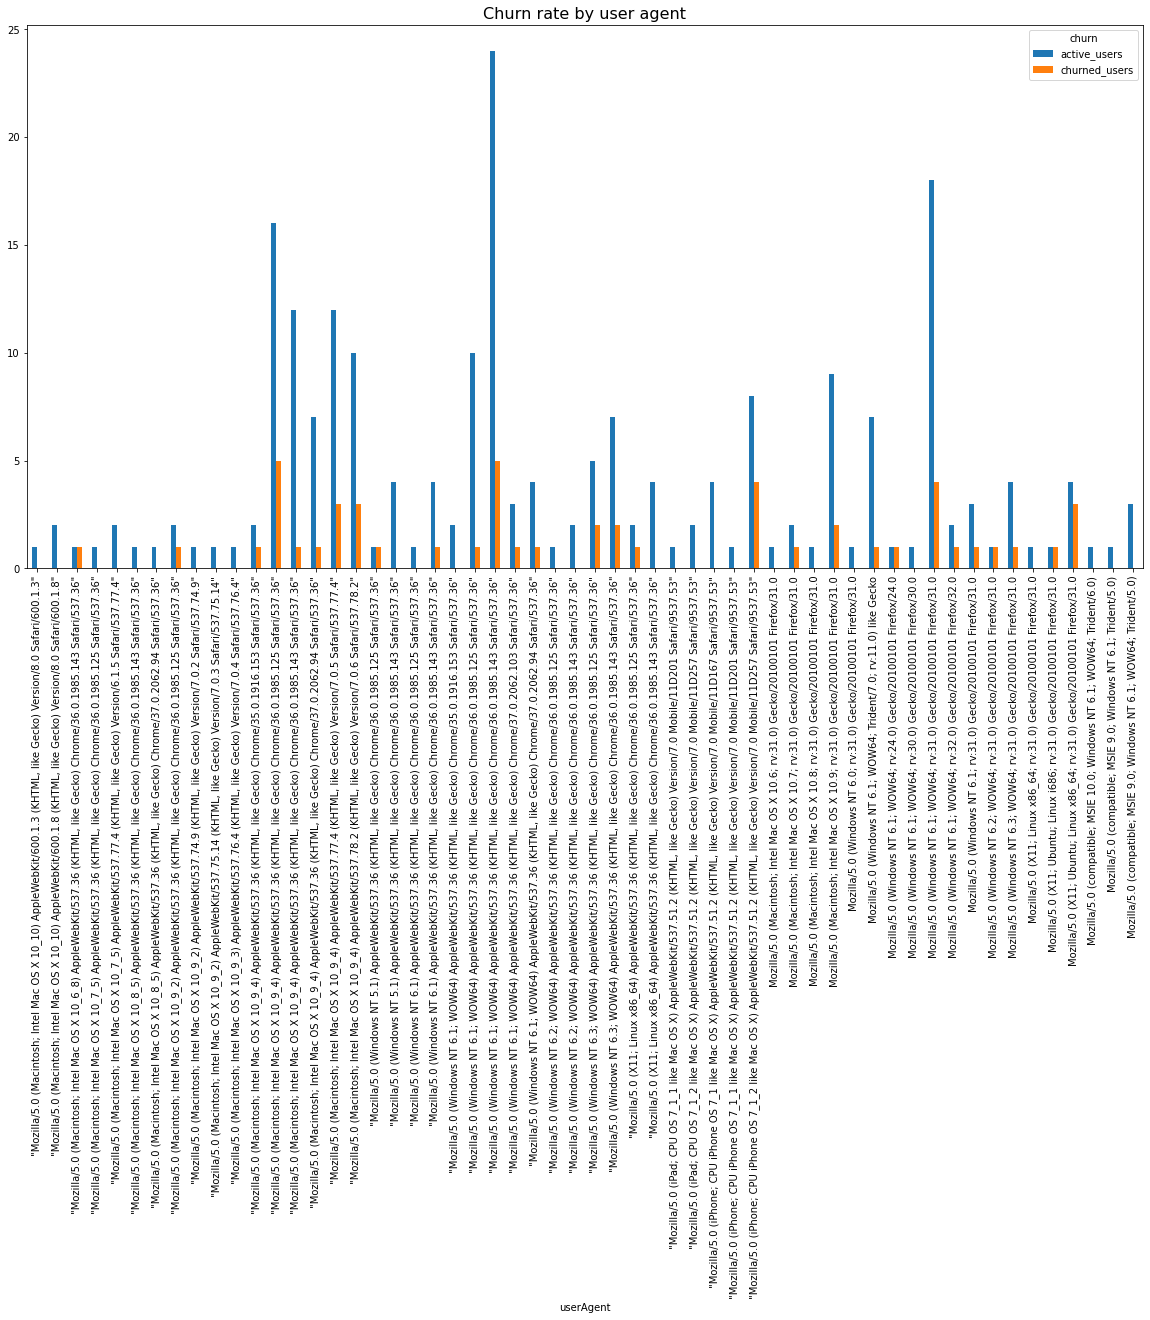

In [57]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
users_churn_userAgent_pd.plot(x = 'userAgent', y = ['active_users', 'churned_users'], ax = ax, kind="bar")
ax.set_title("Churn rate by user agent", fontsize=16);
plt.show()

userAgent needs to be cleaned up to make it more useful. We will extract OS type to make this field more relevant.

In [0]:
# clean user agent field and extract os/device
users_churn_userAgent_pd['user_OS'] = users_churn_userAgent_pd['userAgent'].apply(lambda x: re.search(r'\((.*?)\)', x).group(1))
users_churn_userAgent_pd['user_OS'] = users_churn_userAgent_pd['user_OS'].str.split(';').str[0]
users_churn_userAgent_pd['user_OS'] = users_churn_userAgent_pd['user_OS'].str.split('NT').str[0]

In [0]:
users_churn_userAgent_pd = users_churn_userAgent_pd.groupby('user_OS').sum()
#get_churn_rate(users_churn_userAgent_pd)
users_churn_userAgent_pd.reset_index(level=0, inplace=True)

In [60]:
users_churn_userAgent_pd

churn,user_OS,active_users,churned_users
0,Macintosh,86.0,19.0
1,Windows,106.0,24.0
2,X11,12.0,5.0
3,compatible,5.0,0.0
4,iPad,3.0,0.0
5,iPhone,13.0,4.0


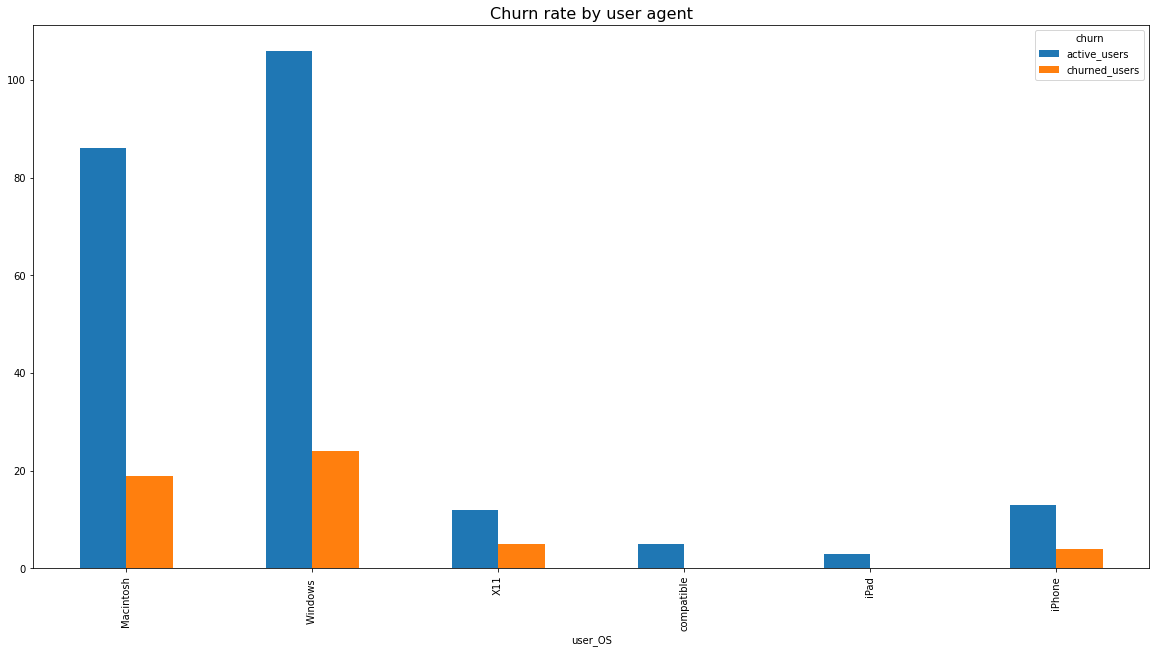

In [61]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
users_churn_userAgent_pd.plot(x = 'user_OS', y = ['active_users', 'churned_users'], ax = ax, kind="bar")
ax.set_title("Churn rate by user agent", fontsize=16);
plt.show()

X11 has the highes churn rate. Churn rate could be higher because of poor performance in specific os or devices. In general this is an important metric to analyzer. Does a particular device/os lead to higher churn?

### Churn by status

In [0]:
users_churn_status = spark.sql('''
          SELECT status, MAX(churn) as churn, COUNT(DISTINCT(userId)) as count_userId
          FROM event_data
          GROUP BY status
          ORDER BY status
          '''
          )

In [63]:
# status has no impact
users_churn_status.show()

+------+-----+------------+
|status|churn|count_userId|
+------+-----+------------+
|   200|    1|         225|
|   307|    0|         223|
|   404|    0|         117|
+------+-----+------------+



Does not look like status has any impact on churn. We will ignore this column while modeling.

### Churn by days since registration

In [0]:
get_subtract_ts = udf(lambda x, y: datetime.datetime.fromtimestamp((y - x) / 1000.0).day)

In [0]:
# By taking max(churn), I am selecting each user id once
users_daysince_reg = spark.sql('''
          SELECT userId, registration, MAX(churn) as churn, MAX(ts) as max_ts
          FROM event_data
          GROUP BY userId, registration
          ORDER BY userId, registration
          '''
          )

In [0]:
users_daysince_reg = users_daysince_reg.\
                    withColumn("days_reg", get_subtract_ts(users_daysince_reg.registration, users_daysince_reg.max_ts))

In [67]:
users_daysince_reg.show()

+------+-------------+-----+-------------+--------+
|userId| registration|churn|       max_ts|days_reg|
+------+-------------+-----+-------------+--------+
|    10|1538159495000|    0|1542631788000|      21|
|   100|1537982255000|    0|1543587349000|       6|
|100001|1534627466000|    1|1538498205000|      14|
|100002|1529934689000|    0|1543799476000|      10|
|100003|1537309344000|    1|1539274781000|      23|
|100004|1528560242000|    0|1543459065000|      22|
|100005|1532610926000|    1|1539971825000|      27|
|100006|1537964483000|    1|1538753070000|      10|
|100007|1533522419000|    1|1543491909000|      26|
|100008|1537440271000|    0|1543335219000|      10|
|100009|1537376437000|    1|1540611104000|       7|
|100010|1538016340000|    0|1542823952000|      25|
|100011|1537970819000|    1|1538417085000|       6|
|100012|1537381154000|    1|1541100900000|      13|
|100013|1537367773000|    1|1541184816000|      14|
|100014|1535389443000|    1|1542740649000|      27|
|100015|1537

In [68]:
users_daysince_reg.groupBy("churn").agg(F.mean("days_reg")).show()

+-----+-----------------+
|churn|    avg(days_reg)|
+-----+-----------------+
|    1|16.23076923076923|
|    0|14.45086705202312|
+-----+-----------------+



If we just look at average time for all users, it's similar between active and churned users.
Let's look at the distribution.

In [0]:
# convert to pandas for visualization
users_daysince_reg_pd = users_daysince_reg.toPandas()
users_daysince_reg_pd['days_reg'] = pd.to_numeric(users_daysince_reg_pd['days_reg'])

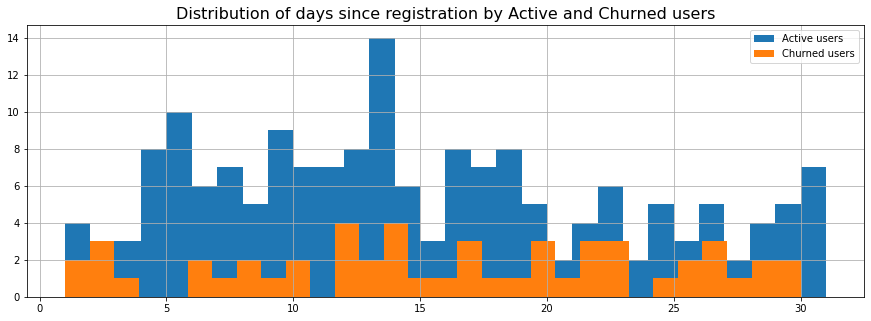

In [70]:
# visualize
df1 = users_daysince_reg_pd[users_daysince_reg_pd.churn == 0].days_reg
df2 = users_daysince_reg_pd[users_daysince_reg_pd.churn == 1].days_reg
fig, ax = plt.subplots(1,1,figsize=(15,5))

df1.hist(bins=30, label="Active users")
df2.hist(bins=30, label="Churned users")
ax.set_title("Distribution of days since registration by Active and Churned users", fontsize=16);
plt.legend();

Active users spend more time on average than churned users.

### Total sessions per users

In [0]:
users_churn_sessionId = spark.sql('''
          SELECT userId, MAX(churn) as churn, COUNT(DISTINCT(sessionId)) as count_sessionId
          FROM event_data
          GROUP BY userId
          ORDER BY userId
          '''
          )

In [72]:
# average number of sessions per user between active and churned users
users_churn_sessionId.groupBy("churn").agg(F.mean('count_sessionId')).show()

+-----+--------------------+
|churn|avg(count_sessionId)|
+-----+--------------------+
|    1|  10.326923076923077|
|    0|  15.254335260115607|
+-----+--------------------+



In [0]:
# convert to pandas for visualization
users_churn_sessionId_pd = users_churn_sessionId.toPandas()
users_churn_sessionId_pd['count_sessionId'] = pd.to_numeric(users_churn_sessionId_pd['count_sessionId'])

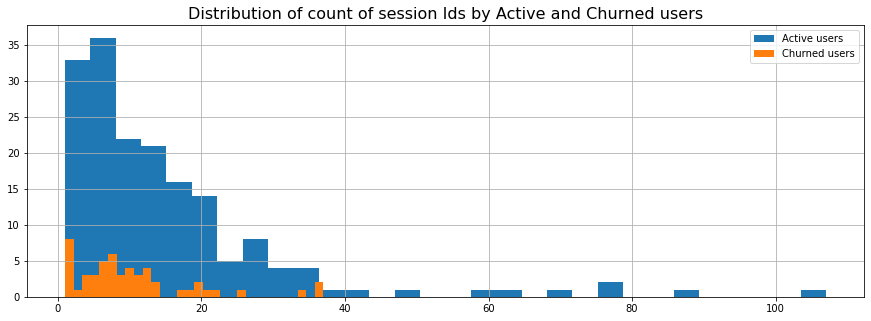

In [74]:
# visualize
df1 = users_churn_sessionId_pd[users_churn_sessionId_pd.churn == 0].count_sessionId
df2 = users_churn_sessionId_pd[users_churn_sessionId_pd.churn == 1].count_sessionId
fig, ax = plt.subplots(1,1,figsize=(15,5))

df1.hist(bins=30, label="Active users")
df2.hist(bins=30, label="Churned users")
ax.set_title("Distribution of count of session Ids by Active and Churned users", fontsize=16);
plt.legend();

As expected more sessions per active users than churned users

#### Average daily sessions per user

In [0]:
avg_daily_sessions_count = spark.sql('''
          SELECT userId, SUM(count_sessionId)/COUNT(day) as daily_avg
          FROM (SELECT userId, day, COUNT(DISTINCT(sessionId)) as count_sessionId
          FROM event_data
          GROUP BY userId, day
          ORDER BY userId, day)
          GROUP BY userId
          ORDER BY userId
          '''
          )

In [0]:
# convert to pandas df and join with df with latest level
avg_daily_sessions_count_pd = avg_daily_sessions_count.toPandas()
avg_daily_sessions_count_pd = pd.merge(avg_daily_sessions_count_pd, users_churn_pd, on='userId')

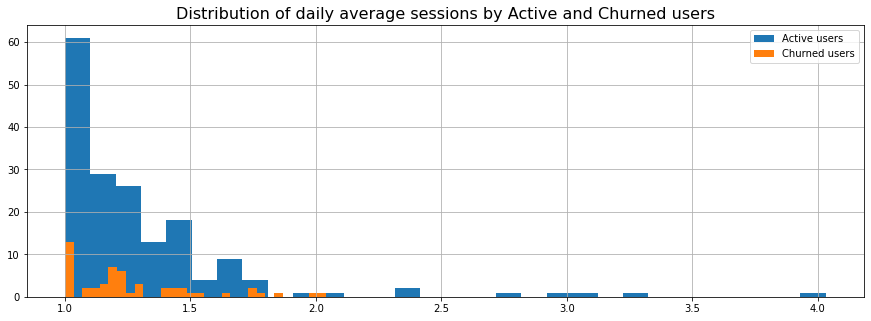

In [77]:
# visualize
df1 = avg_daily_sessions_count_pd[avg_daily_sessions_count_pd.churn == 0].daily_avg
df2 = avg_daily_sessions_count_pd[avg_daily_sessions_count_pd.churn == 1].daily_avg
fig, ax = plt.subplots(1,1,figsize=(15,5))

df1.hist(bins=30, label="Active users")
df2.hist(bins=30, label="Churned users")
ax.set_title("Distribution of daily average sessions by Active and Churned users", fontsize=16);
plt.legend();

In [0]:
avg_mon_sessions_count = spark.sql('''
          SELECT userId, SUM(count_sessionId)/COUNT(month) as monthly_avg
          FROM (SELECT userId, month, COUNT(DISTINCT(sessionId)) as count_sessionId
          FROM event_data
          GROUP BY userId, month
          ORDER BY userId, month)
          GROUP BY userId
          ORDER BY userId
          '''
          )

In [0]:
# convert to pandas df and join with df with latest level
avg_mon_sessions_count_pd = avg_mon_sessions_count.toPandas()
avg_mon_sessions_count_pd = pd.merge(avg_mon_sessions_count_pd, users_churn_pd, on='userId')

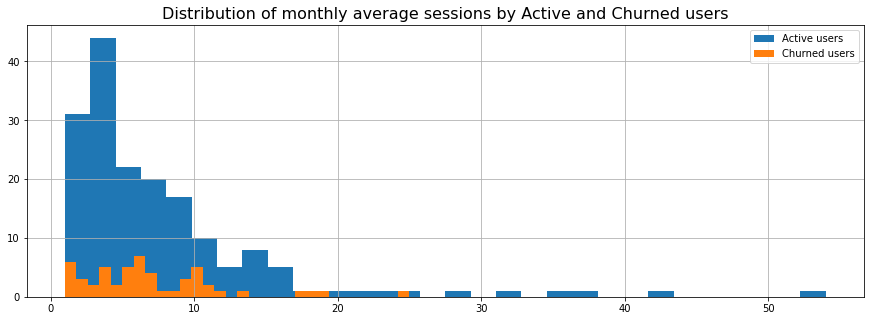

In [80]:
# visualize
df1 = avg_mon_sessions_count_pd[avg_mon_sessions_count_pd.churn == 0].monthly_avg
df2 = avg_mon_sessions_count_pd[avg_mon_sessions_count_pd.churn == 1].monthly_avg
fig, ax = plt.subplots(1,1,figsize=(15,5))

df1.hist(bins=30, label="Active users")
df2.hist(bins=30, label="Churned users")
ax.set_title("Distribution of monthly average sessions by Active and Churned users", fontsize=16);
plt.legend();

Daily and monthly average session count distribution looks similar. I will chose only one of the two for modeling.

#### Average time per session for a User

In [0]:
users_session_duration = spark.sql('''
          SELECT userId, SUM(time_per_session)/COUNT(sessionId) as avg_time_session
          FROM (SELECT userId, sessionId, (MAX(ts) - MIN(ts))/1000 as time_per_session
          FROM event_data
          GROUP BY userId, sessionId
          ORDER BY userId, sessionId)
          GROUP BY userId
          ORDER BY userId
          '''
          )

In [0]:
# convert to pandas df and join with df with latest level
users_session_duration_pd = users_session_duration.toPandas()
users_session_duration_pd = pd.merge(users_session_duration_pd, users_churn_pd, on='userId')

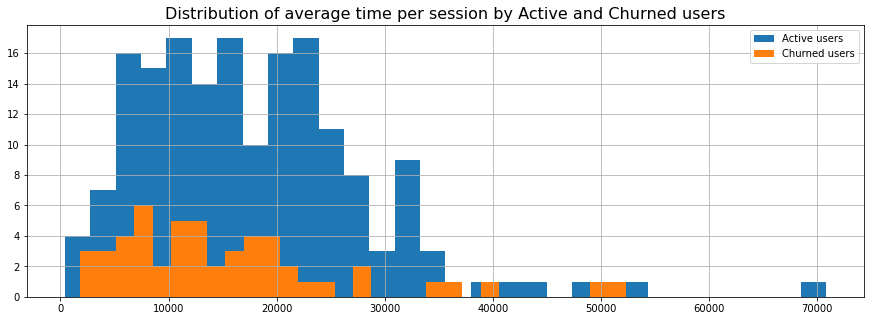

In [83]:
# visualize
df1 = users_session_duration_pd[users_session_duration_pd.churn == 0].avg_time_session
df2 = users_session_duration_pd[users_session_duration_pd.churn == 1].avg_time_session
fig, ax = plt.subplots(1,1,figsize=(15,5))

df1.hist(bins=30, label="Active users")
df2.hist(bins=30, label="Churned users")
ax.set_title("Distribution of average time per session by Active and Churned users", fontsize=16);
plt.legend();

As expected higher session duration for active users.

### Churn by Artists & Songs

Since active users have higher number of sessions and have spent more time on the application, they should have higher count of artists and songs.

In [0]:
users_churn_artist_song = spark.sql('''
          SELECT userId, MAX(churn) as churn, COUNT(DISTINCT(artist)) as count_artist, COUNT(DISTINCT(song)) as count_song
          FROM event_data
          GROUP BY userId
          ORDER BY userId
          '''
          )

In [0]:
# convert to pandas for visualization
users_churn_artist_song_pd = users_churn_artist_song.toPandas()
users_churn_artist_song_pd['count_artist'] = pd.to_numeric(users_churn_artist_song_pd['count_artist'])
users_churn_artist_song_pd['count_song'] = pd.to_numeric(users_churn_artist_song_pd['count_song'])

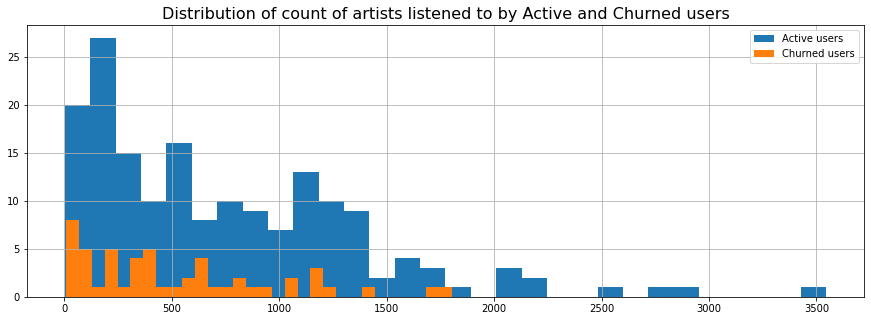

In [86]:
# visualize
df1 = users_churn_artist_song_pd[users_churn_artist_song_pd.churn == 0].count_artist
df2 = users_churn_artist_song_pd[users_churn_artist_song_pd.churn == 1].count_artist
fig, ax = plt.subplots(1,1,figsize=(15,5))

df1.hist(bins=30, label="Active users")
df2.hist(bins=30, label="Churned users")
ax.set_title("Distribution of count of artists listened to by Active and Churned users", fontsize=16);
plt.legend();

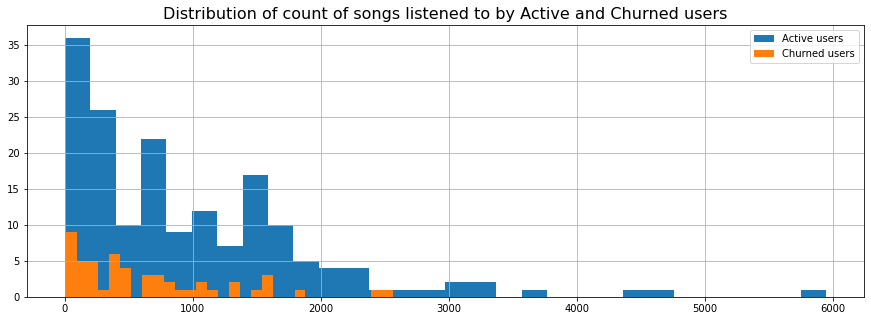

In [87]:
# visualize
df1 = users_churn_artist_song_pd[users_churn_artist_song_pd.churn == 0].count_song
df2 = users_churn_artist_song_pd[users_churn_artist_song_pd.churn == 1].count_song
fig, ax = plt.subplots(1,1,figsize=(15,5))

df1.hist(bins=30, label="Active users")
df2.hist(bins=30, label="Churned users")
ax.set_title("Distribution of count of songs listened to by Active and Churned users", fontsize=16);
plt.legend();

Count of session, artists and songs should have high correlation with active users.
It's obvious, the more conent that the user likes, the more the user will be incentivized to remain an active user. Hence, I will ignore count of artist and songs and focus on session count and duration for modeling.

### Churn by Page views

#### Total page view per User

In [0]:
users_churn_page = spark.sql('''
          SELECT userId, page, COUNT(page) as count_page
          FROM event_data
          GROUP BY userId, page
          ORDER BY userId, page
          '''
          )

In [0]:
users_churn_page_pd = users_churn_page.toPandas()

In [0]:
# merge with users_churn_pd to get churned userIds
users_churn_page_pd = pd.merge(users_churn_page_pd, users_churn_pd, on='userId')

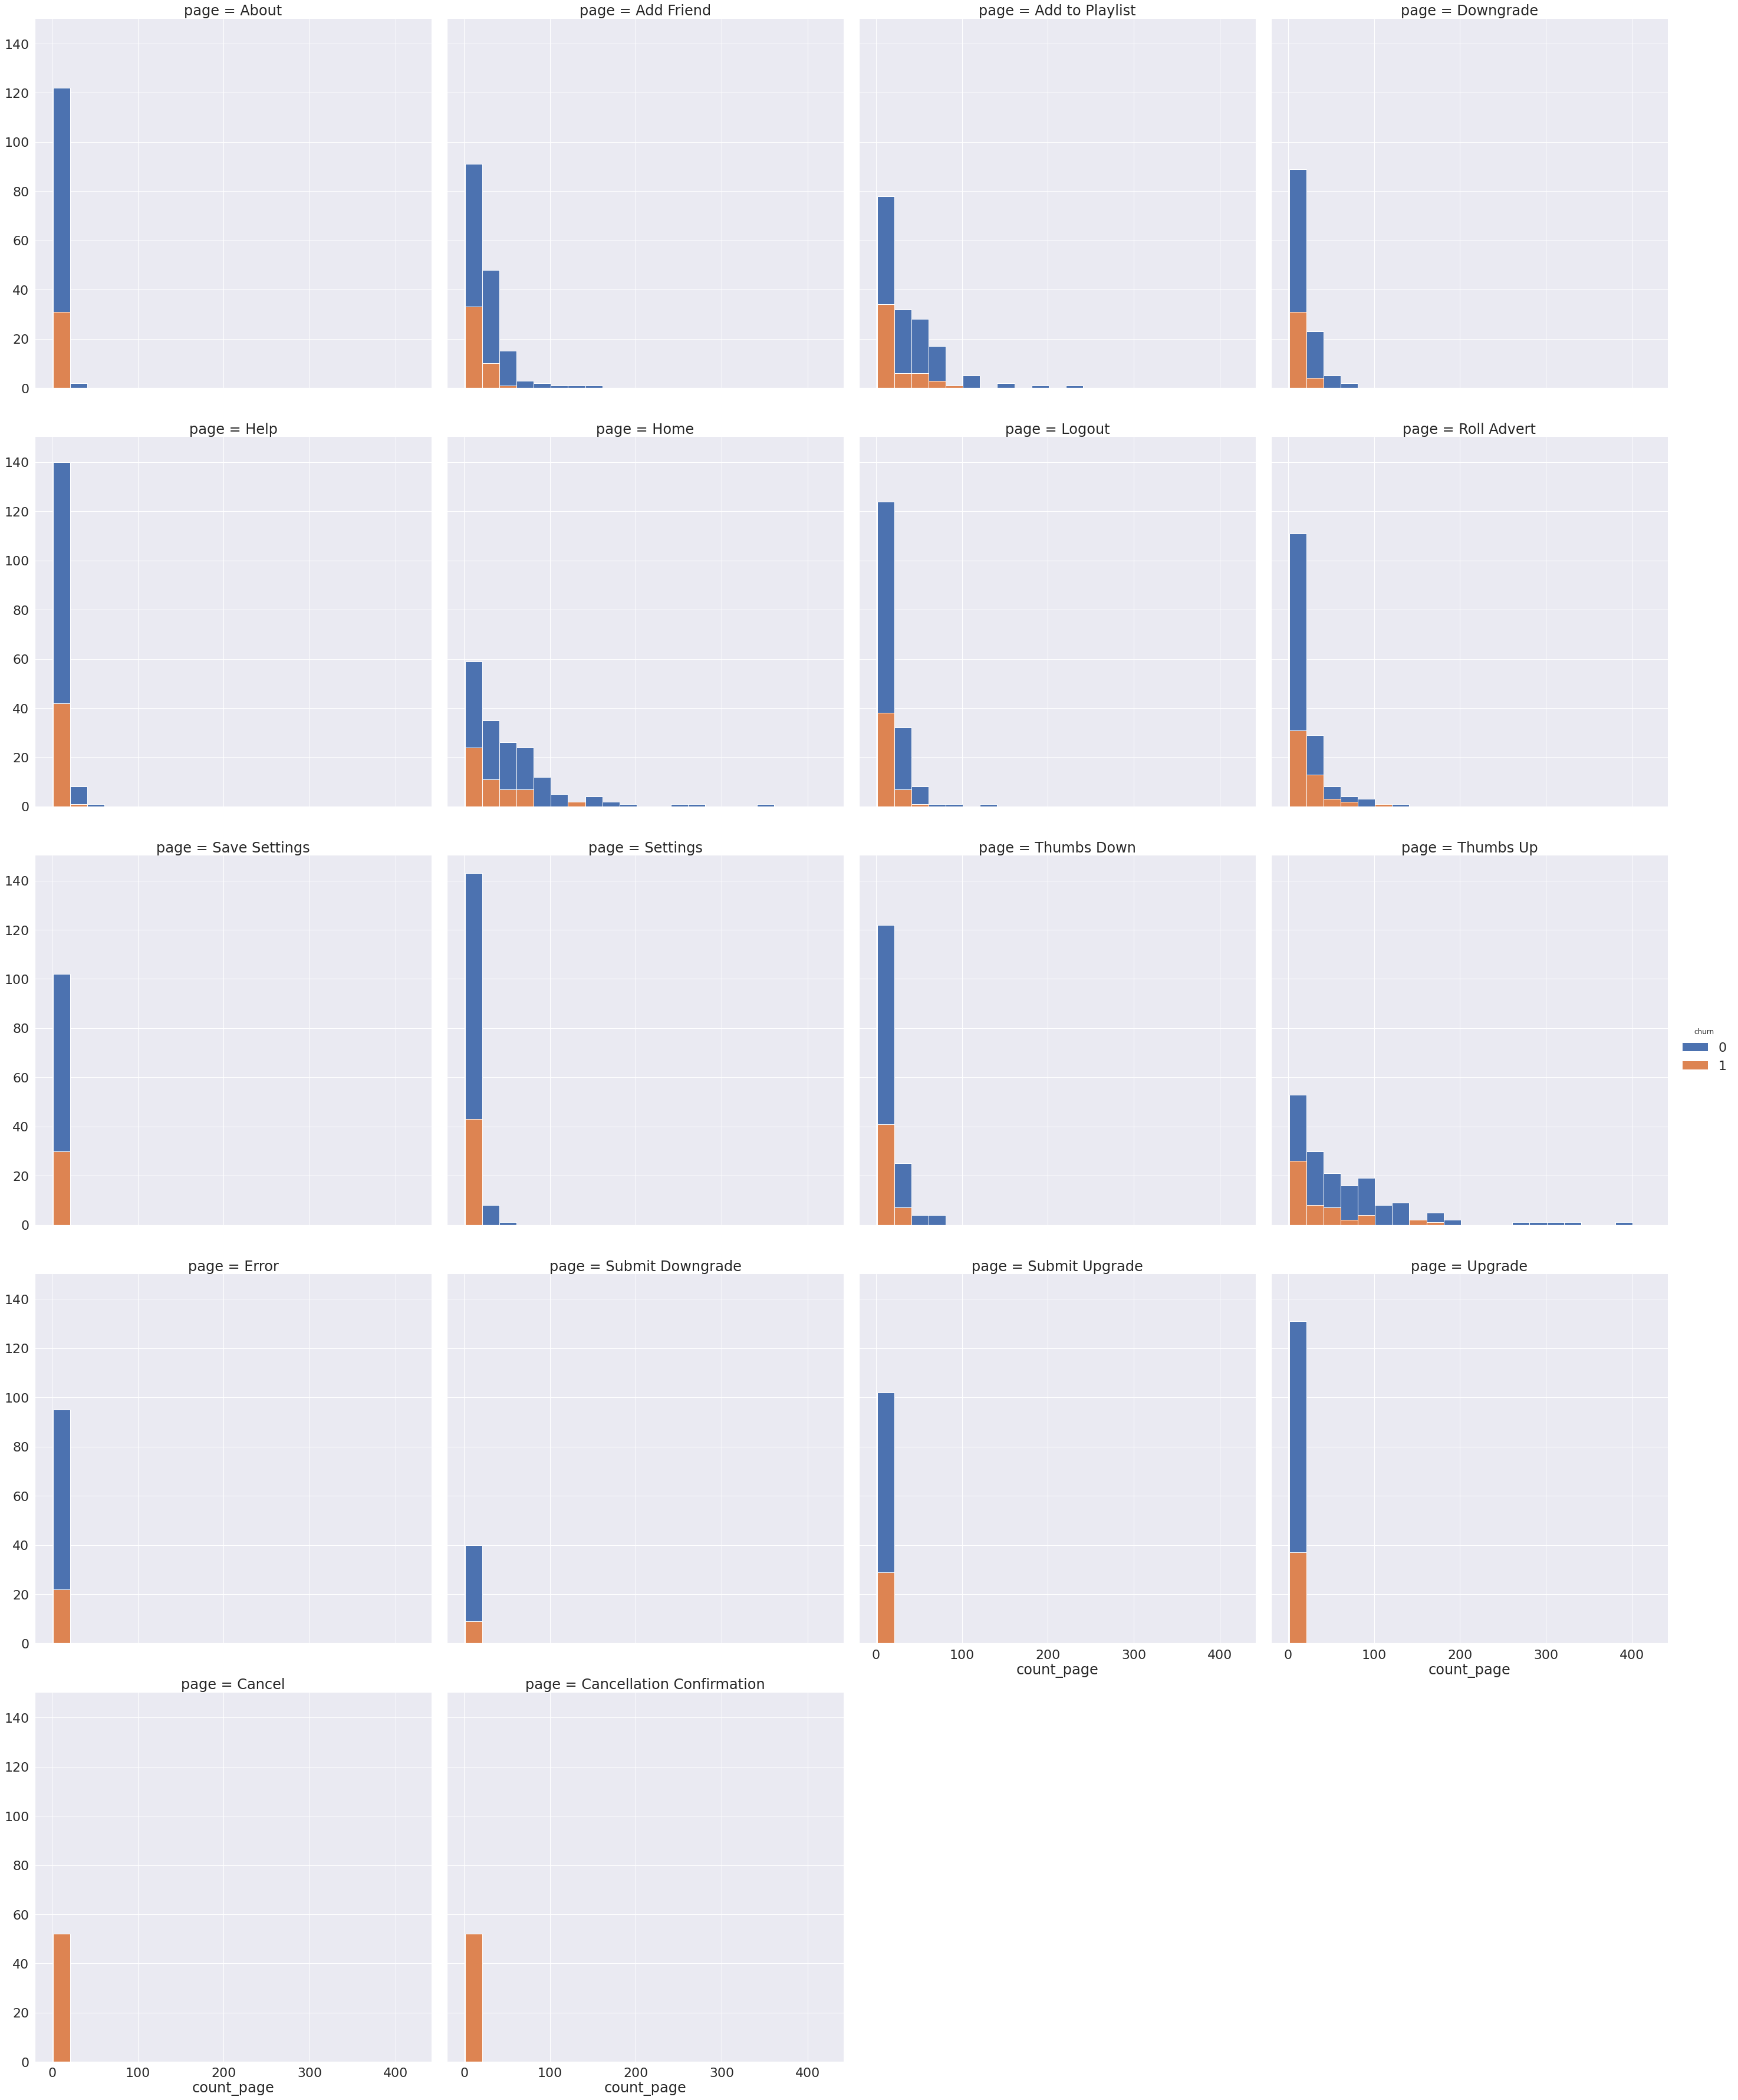

In [91]:
# look at distribution without 'NextSong'
df1 = users_churn_page_pd[users_churn_page_pd['page'] != 'NextSong']
# plot distribution of page views
sns.set(font_scale=2)
bins = np.arange(df1.count_page.min(), df1.count_page.max(), 20)
g = sns.FacetGrid(df1, col="page", hue="churn",col_wrap = 4, height=10)
g = (g.map(plt.hist, "count_page", bins = bins).add_legend());

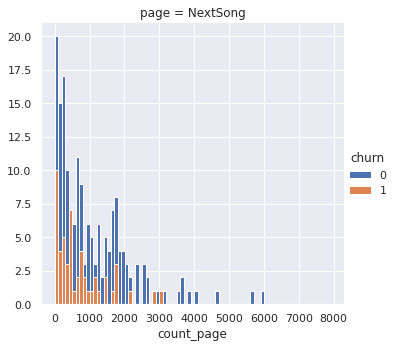

In [97]:
# look at distribution of 'NextSong'
df2 = users_churn_page_pd[users_churn_page_pd['page'] == 'NextSong']
sns.set(font_scale=1)
bins = np.arange(df2.count_page.min(), df2.count_page.max(), 100)
g = sns.FacetGrid(df2, col="page", hue="churn", col_wrap = 1, height=5)
g = (g.map(plt.hist, "count_page", bins = bins).add_legend());

In page views are less from churned users except for 'Cancel' and 'Cancellation Confirmation' page.

#### Monthly average page views per User

In [0]:
users_mon_page = spark.sql('''
          SELECT userId, page, SUM(count_page)/COUNT(month) as avg_mon_page_views
          FROM (SELECT userId, page, month, COUNT(page) as count_page
          FROM event_data
          GROUP BY userId, page, month
          ORDER BY userId, page, month)
          GROUP BY userId, page
          ORDER BY userId, page
          '''
          )

In [0]:
users_mon_page_pd = users_mon_page.toPandas()
users_mon_page_pd = pd.merge(users_mon_page_pd, users_churn_pd, on='userId')

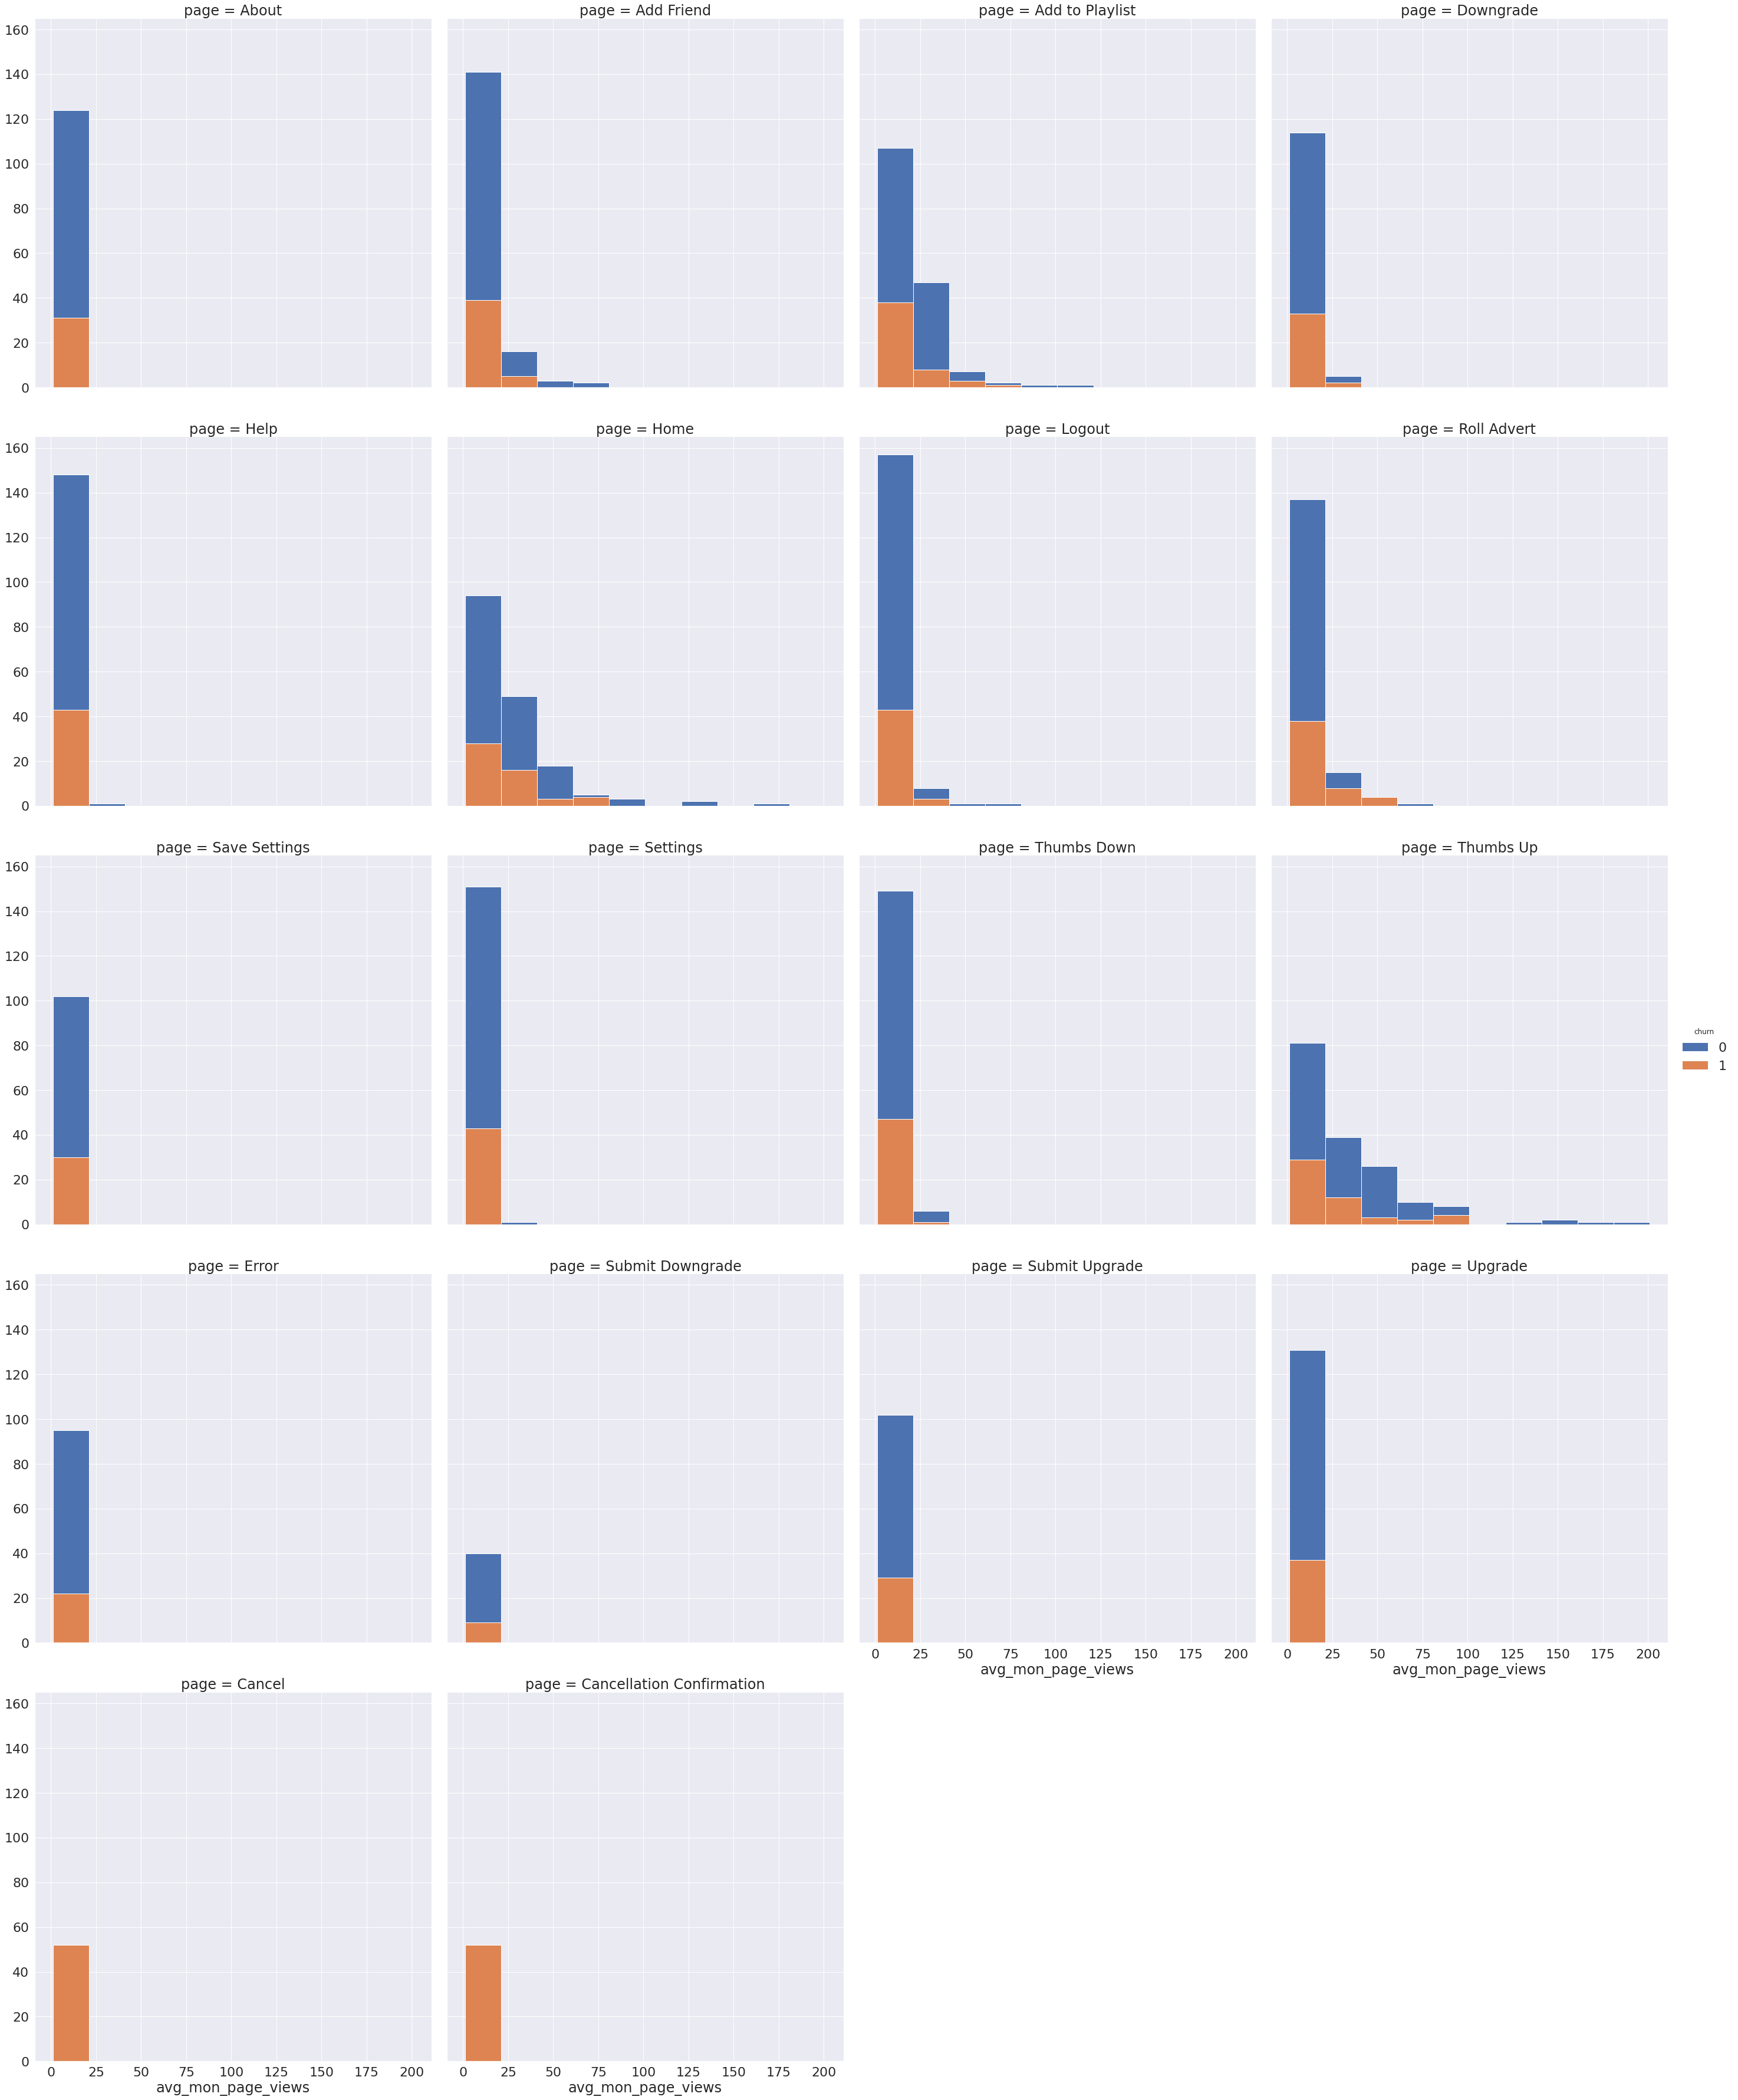

In [95]:
# look at distribution without 'NextSong'
df1 = users_mon_page_pd[users_mon_page_pd['page'] != 'NextSong']
# plot distribution of page views
sns.set(font_scale=2)
bins = np.arange(df1.avg_mon_page_views.min(), df1.avg_mon_page_views.max(), 20)
g = sns.FacetGrid(df1, col="page", hue="churn",col_wrap = 4, height=10)
g = (g.map(plt.hist, "avg_mon_page_views", bins = bins).add_legend());

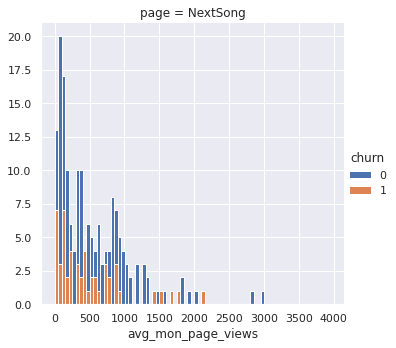

In [96]:
# look at distribution of 'NextSong'
df2 = users_mon_page_pd[users_mon_page_pd['page'] == 'NextSong']
sns.set(font_scale=1)
bins = np.arange(df2.avg_mon_page_views.min(), df2.avg_mon_page_views.max(), 50)
g = sns.FacetGrid(df2, col="page", hue="churn", col_wrap = 1, height=5)
g = (g.map(plt.hist, "avg_mon_page_views", bins = bins).add_legend());

Some of the page views will be highly correlated and hence should be removed during modeling. PCA should take care of that.

I will use data exploration performed here to perform feature extraction for modeling.